# CWN general features

In [1]:
# Setting paths
import sys,os
import pathlib
sys.path.insert(0,os.path.expanduser('~/caryocar'))
sys.path.insert(0,os.path.abspath('..'))

In [2]:
# Building the networks from data
from setupmodels import *

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib as mpl
import seaborn as sns
import scipy as scp 

import matplotlib.pyplot as plt

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-paper')
sns.set_color_codes('deep')

%matplotlib inline

In [4]:
# plot style params
sns.set_color_codes('deep')
plt.rc('figure', figsize=(8,5))

empty_circle={'markerfacecolor':'none','markeredgewidth':1.3,'ms':10,'marker':'o','ls':''}
xes={'markerfacecolor':'none','markeredgewidth':1.3,'ms':10,'marker':'x','ls':''}

---

### General info

In [5]:
print(nx.info(cwn))

Name: 
Type: CoworkingNetwork
Number of nodes: 6768
Number of edges: 10391
Average degree:   3.0706


In [6]:
num_cols = cwn.number_of_nodes()

* How many singleton collaborators (Not a single collaboration, $k=0$) ?

In [7]:
num_singletons = len(set(nx.isolates(cwn)))
num_singletons

2673

In [8]:
"Percentage of singletons: {:.2%}".format(num_singletons/cwn.number_of_nodes())

'Percentage of singletons: 39.49%'

In [9]:
print("Overall density of the CWN network: {:.5f}".format(nx.density(cwn)))

Overall density of the CWN network: 0.00045


---

### Connected components

In [10]:
sgs = list(nx.connected_component_subgraphs(cwn))
sgs = sorted(sgs,key=lambda g: g.number_of_nodes(),reverse=True)

In [11]:
giantComp = sgs[0]
connectedComps = sgs[1:]

In [12]:
print("Number of components: {}".format(len(sgs)))

Number of components: 2991


In [13]:
print("Size of the giant component: {} nodes, {:.2%}".format( 
    giantComp.number_of_nodes(),
    giantComp.number_of_nodes()/cwn.number_of_nodes()
))

Size of the giant component: 3114 nodes, 46.01%


In [14]:
print("Density of the giant component: {:.5f}".format(nx.density(giantComp)))

Density of the giant component: 0.00195


In [15]:
print("Sizes of the top-10 connected components (excluding c1):\n"+\
"\n".join( ["\tConnected comp c{}: {} nodes".format(i+2, sg.number_of_nodes()) for i,sg in enumerate(connectedComps[:10])]))


Sizes of the top-10 connected components (excluding c1):
	Connecte comp c2: 59 nodes
	Connecte comp c3: 20 nodes
	Connecte comp c4: 16 nodes
	Connecte comp c5: 15 nodes
	Connecte comp c6: 10 nodes
	Connecte comp c7: 9 nodes
	Connecte comp c8: 9 nodes
	Connecte comp c9: 9 nodes
	Connecte comp c10: 8 nodes
	Connecte comp c11: 8 nodes


In [16]:
print("Average size of isolated components: {:.3}".format( np.mean([ sg.number_of_nodes() for sg in connectedComps ]) ))

Average size of isolated components: 1.22


* All singletons are an isolated component (this is why there are so many of them)

In [17]:
print("Number of non-singleton isolated components: {}".format( sum( 1 for sg in connectedComps if sg.number_of_nodes()>1 ) ))

Number of non-singleton isolated components: 317


#### Singleton collectors

How many singleton collectors?

In [18]:
isolated_nodes = [ list(comp.nodes)[0] for comp in connectedComps if len(comp.nodes)==1 ]

In [19]:
len(isolated_nodes)

2673

Who are the most important of these?

In [20]:
# collector, num of recs
col_nrecs = sorted([ (i,len(ni[i])) for i in isolated_nodes ], key=lambda x: x[1], reverse=True)
col_nrecs[:10]

[('leite,alta', 2757),
 ('touw,a', 375),
 ('schiffner,v', 283),
 ('oliveira,e', 252),
 ('coelho,gsf', 227),
 ('rocha,mal', 165),
 ('aquino,ppu', 155),
 ('pinto,rnm', 144),
 ('silva,nf', 133),
 ('nitikman,lz', 131)]

What is the proportion of records collected by *leite,alta*, considering all contributions by singleton collectors?

In [21]:
"{:.2%}".format(col_nrecs[0][1] / sum(list(zip(*col_nrecs))[1]))

'18.14%'

How many records by singleton collectors have been recorded in Brazil?

In [22]:
isolated_nodes_occs = set( ix for i in isolated_nodes for ix in ni[i])

In [23]:
occs.loc[isolated_nodes_occs]['countryCode'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')[:5]

BR    81.08%
ID     2.73%
US     2.62%
AU     1.91%
PG     1.48%
Name: countryCode, dtype: object

---

### Team Sizes

In [384]:
# avg team size
occs['recordedBy_atomized'].apply(len).mean()

1.7274678393279075

In [355]:
x,y = zip( *occs['recordedBy_atomized'].apply(len).value_counts().items())

In [367]:
y=[ i/sum(y) for i in y ]

In [368]:
#Transform y
y_transf = list(map(lambda x: np.log10(x), y))

# fit with transformed y
f = lambda x,b0,b1: b0+b1*x
(b0,b1),cov = scp.optimize.curve_fit(f, x[:-1], y_transf[:-1]) # The last point is not used for fitting!

In [382]:
b0,b1

(0.15565328522708521, -0.37717744613512005)

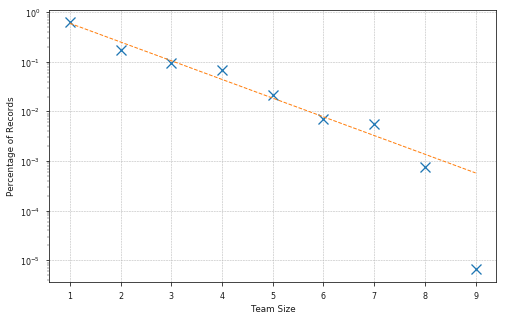

In [380]:
# Plot figure in log-lin scale

plt.figure(figsize=(8,5))
plt.plot(x,y,**xes)
plt.plot(x,[ (10**(b0+b1*i)) for i in x ], ls='--',lw=1)

plt.yscale('log')
plt.grid(linewidth=0.5, ls='--',color='.7')
plt.xlabel('Team Size')
plt.ylabel('Percentage of Records')
plt.savefig('team_sizes_pcts.pdf', dpi=92, bbox_inches='tight')

Only one record with $team\_size>8$. It appears the names string has been truncated.

In [27]:
pd.options.display.max_colwidth=100

In [28]:
occs[occs['recordedBy_atomized'].apply(len)==9]['recordedBy'].iloc[0]

'Faria, JEQ; Proença, C; Concha, C; Reis, PA; Rosa, PO; Izetti, C; Mello, TRB; Oku, W; Mende'

Collectors names strings from records with $team\_size = 8$ have also been truncated.

In [29]:
occs[occs['recordedBy_atomized'].apply(len)==8]['recordedBy'].value_counts()

Haidar, RF; Matos, MQ; Fagg, CW; Felfili, JM; Mendonça, RC; Proença, CEB; Farias, R; Rodrig      34
Matos, MQ; Haidar, RF; Fagg, CW; Felfili, JM; Mendonça, RC; Proença, CEB; Farias, R; Rodri       31
Faria, JEQ; Câmara, PEAS; Costa, DP; Martins, DS; Amorim, PRF; Sousa, RV; Gonzaga, RMO; Car      29
Faria, JEQ; Campos, LZO; Ibrahim, M; Martins, RC; Caires, CS; Meneguzzo, TEC; Souza, LF; Nu      13
Martins, DS; Câmara, PEAS; Amorim, PRF; Costa, DP; Faria, JEQ; Carvalho, AM; Gonzaga, RMO; S      3
Henderson, A; Cid, CA; Lima, J; Alves, J; Rickson, F; Parker, D; Aulino, O; Rodrigues, K          2
Walter, BMT; Silva, GP; Xavier, S; Rocha, F; Santos, H; Silva, S; Tavares, G; Mendonça, R         1
Ratter, JA; Bridgewater, S; Cardoso, E; Fonseca, J; Lima, V; Passon, L; Santos, RR; Sanaiot       1
Ratter, JA; Bridgewater, S; Cardoso, E; Lima, V; Munhoz, CBR; Oliveira, NR; Ribeiro, JF; Si       1
Harley, RM; Giulietti, AM; Stannard, BL; Hind, DJN; Kameyama, C; Prado, J; Rudall, P; Simão       1


---

### Degree Distribution

In [30]:
import powerlaw

In [31]:
k_hist = nx.degree_histogram(cwn)
sum_degrees = sum(k_hist)
h = list(zip( range(len(k_hist)), k_hist ))
h_pct = [ (k,cnt/sum_degrees) for k,cnt in h ]

In [32]:
# Fitting a powerlaw
data_expanded=[ k for k,cnt in h for i in range(cnt) if k>0 ] 
fit = powerlaw.Fit(data_expanded,discrete=True,xmin=3)

dist=fit.power_law
alpha=dist.alpha

f=lambda x, alpha,a1: a1*pow(x,-alpha) # powerlaw

/home/pedro/anaconda3/envs/tese_lncc/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


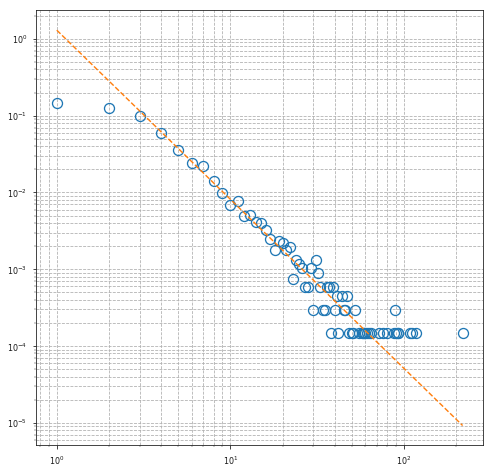

In [166]:
x,y = zip(*h_pct[1:])


plt.figure(figsize=(8,8))
plt.plot(x,y, **empty_circle)
plt.plot(x,f(x,alpha,1.3),ls='--')
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both', ls='--')

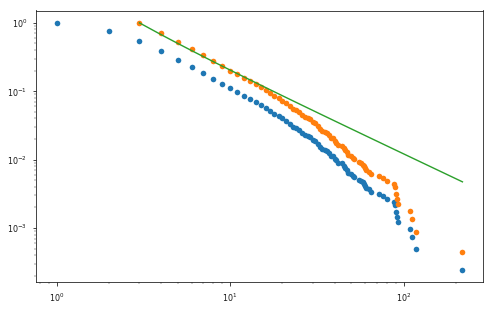

In [163]:
ax=fit.plot_ccdf(marker='o',ls='', original_data=True)
fit.plot_ccdf(marker='o',ls='', original_data=False)
fit.power_law.plot_ccdf(ax=ax)

In [22]:
alpha

2.2020691084877004

* Singleton collectors (0 collaborations) are omitted from the figure

---

### Most central collectors

Average degrees for *(i)* the entire network; *(ii)* the giant component; *(iii)* all connected components excluding $c_1$.

In [54]:
print("Overall average degree: {:.2f}".format(sum( k for n,k in list(cwn.degree()) )/cwn.number_of_nodes()))

Overall average degree: 3.07


In [55]:
print("Giant component average degree: {:.2f}".format( sum(k for n,k in list(giantComp.degree()))/giantComp.number_of_nodes() ))

Giant component average degree: 6.08


In [81]:
num_nodes = sum( 1 for comp in connectedComps for node in comp.nodes() )
print("Average degree <k> for all connected components (excluding c1): {:.2f}".format(
    sum( cwn.degree(node) for comp in connectedComps for node in comp.nodes() )/num_nodes))

Average degree <k> for all connected components (excluding c1): 0.51


Create a latex table: top-20 collectors (ordered by degree $k$)

In [305]:
def getNumCollabRecords(col,pct=False):
    o=occs.loc[ni[col]]
    o_collab = o[o['recordedBy_atomized'].apply(len)>1]
    if pct:
        return o_collab.shape[0]/o.shape[0]
    return o_collab.shape[0]

# Make table data
table_data = [  (  col, 
                   d['count'], 
                   getNumCollabRecords(col,pct=True),
                   cwn.degree(col), 
                   cwn.degree(col,weight='weight_hyperbolic') ) for col,d in cwn.nodes(data=True)]

In [316]:
table_data = sorted(table_data,key=lambda x: x[4],reverse=True)
table_data[:20]

[('irwin,hs', 18065, 0.341489067257127, 39, 5696.000000000027),
 ('proenca,ceb', 4803, 0.8825733916302311, 218, 4203.6666666666615),
 ('faria,jeq', 4687, 0.8291071809077349, 117, 3881.0000000000205),
 ('souza,rr', 3885, 0.9927965011577051, 37, 3835.500000000027),
 ('santos,rrb', 3587, 0.9445218845832172, 41, 3382.2500000000327),
 ('munhoz,cbr', 3191, 0.8282670009401442, 109, 2493.1666666666656),
 ('zanatta,mrv', 2364, 0.9576988155668359, 50, 2264.0000000000173),
 ('castelobranco,cw', 2256, 1.0, 1, 2256.0),
 ('grando,jv', 2256, 1.0, 1, 2256.0),
 ('eiten,g', 3046, 0.6138451443569554, 33, 1865.5),
 ('amaral,ag', 1825, 0.9950684931506849, 37, 1814.9999999999977),
 ('projetobiodiversidadebp', 1780, 1.0, 19, 1779.9999999999977),
 ('mendes,vc', 1696, 0.9994103773584906, 89, 1695.0000000000014),
 ('fonseca,sf', 1610, 0.999379652605459, 18, 1606.9999999999802),
 ('camara,peas', 2076, 0.7976878612716763, 47, 1485.9999999999998),
 ('harley,rm', 2564, 0.6599063962558502, 90, 1455.833333333333),
 (

In [317]:
# col, num_recs, pct_recs_collaborative, k, k_w (hyperbolic)
table = ""
for row in table_data[:20]:
    table += '{} & {} & {:.1%} & {} & {:.1f} \\\\\n'.format(*row).replace('%','')

print(table)

irwin,hs & 18065 & 34.1 & 39 & 5696.0 \\
proenca,ceb & 4803 & 88.3 & 218 & 4203.7 \\
faria,jeq & 4687 & 82.9 & 117 & 3881.0 \\
souza,rr & 3885 & 99.3 & 37 & 3835.5 \\
santos,rrb & 3587 & 94.5 & 41 & 3382.3 \\
munhoz,cbr & 3191 & 82.8 & 109 & 2493.2 \\
zanatta,mrv & 2364 & 95.8 & 50 & 2264.0 \\
castelobranco,cw & 2256 & 100.0 & 1 & 2256.0 \\
grando,jv & 2256 & 100.0 & 1 & 2256.0 \\
eiten,g & 3046 & 61.4 & 33 & 1865.5 \\
amaral,ag & 1825 & 99.5 & 37 & 1815.0 \\
projetobiodiversidadebp & 1780 & 100.0 & 19 & 1780.0 \\
mendes,vc & 1696 & 99.9 & 89 & 1695.0 \\
fonseca,sf & 1610 & 99.9 & 18 & 1607.0 \\
camara,peas & 2076 & 79.8 & 47 & 1486.0 \\
harley,rm & 2564 & 66.0 & 90 & 1455.8 \\
carvalhosilva,m & 1635 & 98.5 & 58 & 1436.0 \\
eiten,lt & 1262 & 99.6 & 14 & 1256.5 \\
mello,trb & 1247 & 100.0 & 21 & 1247.0 \\
soares,aer & 1557 & 73.0 & 29 & 1135.0 \\



#### Plot: $k$ and $k_w$ top-10 ranks

In [188]:
#cols = set( c for c,k in rank_cols_k[:10] ) | set( c for c,k in rank_cols_kw[:10] )
#data=list(zip(*[ (col, dict(rank_cols_k)[col], dict(rank_cols_kw)[col] ) for col in cols ]))

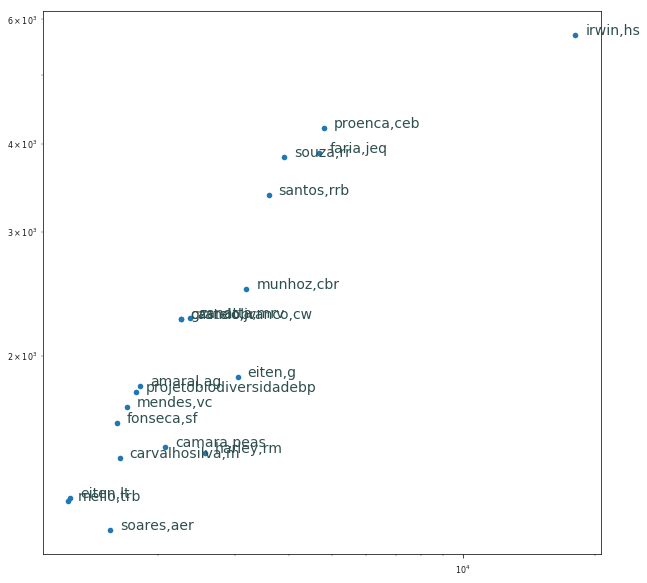

In [352]:
t,x,y = list(zip(*[ (col,nrecs,kw) for col,nrecs,pctcollab,k,kw in table_data[:20]]))

plt.figure(figsize=(10,10))
plt.plot(x,y,'o',label='c')

for t,x,y in zip(*data):
    plt.annotate(t, xy=(x,y),xytext=(10, 0),textcoords='offset points',
                family='sans-serif', fontsize=14, color='darkslategrey')


#plt.xlabel('# distinct collaborators ($k$)')
#plt.ylabel('$k_w$ (Hyperbolic weighting)')
plt.xscale('log')
plt.yscale('log')

* If we compare both rankings, only 3 collectors from 10 are shared

In [129]:
set([ i[0] for i in top10_cols_k]) & set([ i[0] for i in top10_cols_kw ])

NameError: name 'top10_cols_k' is not defined

In [31]:
"Position of 'irwin,hs' in the rank k: {}th, with k={}".format(
    *[ (i+1,k) for i,(c,k) in enumerate(rank_cols_k) if c=='irwin,hs'][0] )

"Position of 'irwin,hs' in the rank k: 43th, with k=39"

In [32]:
"Position of 'ratter,ja' in the rank kw: {}th, with kw={}".format(
    *[ (i+1,k) for i,(c,k) in enumerate(rank_cols_kw) if c=='ratter,ja' ][0])

"Position of 'ratter,ja' in the rank kw: 20th, with kw=2962"

---

### Assortativity

In [33]:
# According to Newman 2003 - Mixing patterns in networks (eq21)
nx.assortativity.degree_assortativity_coefficient(cwn)


-0.0034149148149912904

In [34]:
nx.assortativity.degree_assortativity_coefficient( giantComp )

-0.030843411351555172

In [43]:
nx.write_gexf(cwn,'./g.gexf')

KeyError: <class 'NoneType'>

In [ ]:
!gephi g.gexf

In [51]:
nx.set_edge_attributes(cwn,'','taxons')

In [57]:
nx.write_gexf(cwn,'./g.gexf')